# Init

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

# Simple implementation

In [2]:
env = gym.make('CartPole-v1')

In [ ]:
# TRAINING - RANDOM WEIGHTS
MAX_MOVES = 500 #Cartpole-v1

best_length = 0
best_weights = None

for weights in tqdm(range(100)):
    weights_arr = np.random.uniform(-1,1,4)
    game_lengths = []

    for game in range(100):

        observation = env.reset()
        for moves in range(MAX_MOVES):
            # env.render()
            action = 1 if(np.dot(weights_arr, observation) > 0) else 0 
            observation, reward, done, info = env.step(action)

            if(done):
                game_lengths.append(moves)
                break

    average_length = sum(game_lengths) / len(game_lengths)
    if (average_length > best_length):
        best_length = average_length
        best_weights = weights_arr

print("\nBEST LENGTH: ",best_length)

In [ ]:
# TESTING
weights_arr = best_weights

observation = env.reset()
for moves in tqdm(range(MAX_MOVES)):
    env.render()
    action = 1 if(np.dot(weights_arr, observation) > 0) else 0 
    observation, reward, done, info = env.step(action)

    if(done):
        print("MOVES: ",moves)
        break

env.close()

# Q-Learning & SARSA

In [2]:
env = gym.make('CartPole-v0')

In [3]:
# DISCRETIZING CONTINUOUS SPACE
def create_bins():
    bins = np.zeros((4,10))
    bins[0] = np.linspace(-2.4, 2.4, 10)
    bins[1] = np.linspace(-5, 5, 10)
    bins[2] = np.linspace(-0.418, 0.418, 10)
    bins[3] = np.linspace(-5, 5, 10)
    return bins

# GIVEN OBSERVATION ARRAY AND BINS, RETURNS STATE NUMBER
def get_state(observation, bins):
    state = [None] * 4
    for i in range(4):
        state[i] = int(np.digitize(observation[i], bins[i]) - 1)
    return tuple(state)

## Q-Learning

In [7]:
#GET ACTION BY POLICY (e-GREEDY)
def get_action(Q, state, epsilon):
    if (np.random.uniform() < epsilon):
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

#PLAY SINGLE EPISODE - Q-Learning
def play_episode(Q, bins, epsilon):
    total_reward = 0

    observation = env.reset()
    state = get_state(observation, bins)
    
    for moves in range(MAX_MOVES):
        # e-GREEDY
        action = get_action(Q, state, epsilon)

        # TAKE ACTION
        observation_, reward, done, _ = env.step(action)

        # PUNISH FOR FAILURE
        if( done and (moves < (MAX_MOVES - 5)) ):
            reward = -300
        total_reward += reward

        # UPDATE Q-VALUES (greedify - Off policy)
        state_ = get_state(observation_, bins)
        actionMAX_ = np.argmax(Q[state_])
        qMAX_ = Q[state_, actionMAX_]
        Q[state, action] += (ALPHA * (reward + (GAMMA * qMAX_) - Q[state, action]))

        state = state_

        # BREAK IF TERMINATED
        if(done): break 

    return (round(total_reward), round(moves))

In [8]:
# INIT
MAX_STATES = 10 ** 4
MAX_MOVES = env._max_episode_steps #200
NUM_EPISODES = 3000
GAMMA = 0.9
ALPHA = 0.01
EPSILON = 0.5 #OVERRIDDEN

Q = np.zeros((10, 10, 10, 10, env.action_space.n))
episode_rewards = []
episode_lengths = []
bins = create_bins()

In [9]:
#TRAINING

# progress = tqdm(range(NUM_EPISODES))
for episode_n in range(NUM_EPISODES):
    EPSILON = 1 / np.sqrt(episode_n + 1)
    if(EPSILON < 0.01): EPSILON = 0.01
    
    episode_reward, episode_length = play_episode(Q, bins, EPSILON)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    if(episode_n%100 == 0):
        print("ITER: ",(episode_n),"\tREWARD: ",episode_reward ,"\tLENGTH: ",episode_length)

ITER:  0 	REWARD:  -288 	LENGTH:  12
ITER:  100 	REWARD:  -288 	LENGTH:  12
ITER:  200 	REWARD:  -283 	LENGTH:  17
ITER:  300 	REWARD:  -225 	LENGTH:  75
ITER:  400 	REWARD:  -212 	LENGTH:  88
ITER:  500 	REWARD:  -224 	LENGTH:  76
ITER:  600 	REWARD:  200 	LENGTH:  199
ITER:  700 	REWARD:  200 	LENGTH:  199
ITER:  800 	REWARD:  200 	LENGTH:  199
ITER:  900 	REWARD:  -140 	LENGTH:  160
ITER:  1000 	REWARD:  -121 	LENGTH:  179
ITER:  1100 	REWARD:  200 	LENGTH:  199
ITER:  1200 	REWARD:  200 	LENGTH:  199
ITER:  1300 	REWARD:  200 	LENGTH:  199
ITER:  1400 	REWARD:  200 	LENGTH:  199
ITER:  1500 	REWARD:  200 	LENGTH:  199
ITER:  1600 	REWARD:  200 	LENGTH:  199
ITER:  1700 	REWARD:  200 	LENGTH:  199
ITER:  1800 	REWARD:  200 	LENGTH:  199
ITER:  1900 	REWARD:  200 	LENGTH:  199
ITER:  2000 	REWARD:  200 	LENGTH:  199
ITER:  2100 	REWARD:  200 	LENGTH:  199
ITER:  2200 	REWARD:  200 	LENGTH:  199
ITER:  2300 	REWARD:  -115 	LENGTH:  185
ITER:  2400 	REWARD:  200 	LENGTH:  199
ITER:  25

## SARSA

In [4]:
#GET ACTION BY POLICY (e-GREEDY)
def get_action(Q, state, epsilon):
    if (np.random.uniform() < epsilon):
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

#PLAY SINGLE EPISODE - SARSA
def play_episode(Q, bins, epsilon):
    total_reward = 0

    observation = env.reset()
    state = get_state(observation, bins)
    action = get_action(Q, state, epsilon)
    
    for moves in range(MAX_MOVES):

        # TAKE ACTION
        observation_, reward, done, _ = env.step(action)
        state_ = get_state(observation_, bins)
        # e-GREEDY
        action_ = get_action(Q, state_, epsilon)

        # PUNISH FOR FAILURE
        if( done and (moves < (MAX_MOVES - 5)) ):
            reward = -300
        total_reward += reward

        # UPDATE Q-VALUES (On policy)
        q_ = Q[state_, action_]
        Q[state, action] += (ALPHA * (reward + (GAMMA * q_) - Q[state, action]))

        state, action = state_, action_

        # BREAK IF TERMINATED
        if(done): break 

    return (round(total_reward), round(moves))

In [5]:
# INIT
MAX_STATES = 10 ** 4
MAX_MOVES = env._max_episode_steps #200
NUM_EPISODES = 3000
GAMMA = 0.9
ALPHA = 0.01
EPSILON = 0.5 #OVERRIDDEN

Q = np.zeros((10, 10, 10, 10, env.action_space.n))
episode_rewards = []
episode_lengths = []
bins = create_bins()

In [6]:
#TRAINING

# progress = tqdm(range(NUM_EPISODES))
for episode_n in range(NUM_EPISODES):
    EPSILON = 1 / np.sqrt(episode_n + 1)
    if(EPSILON < 0.01): EPSILON = 0.01

    episode_reward, episode_length = play_episode(Q, bins, EPSILON)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    if(episode_n%100 == 0):
        print("ITER: ",(episode_n),"\tREWARD: ",episode_reward ,"\tLENGTH: ",episode_length)

ITER:  0 	REWARD:  -288 	LENGTH:  12
ITER:  100 	REWARD:  -235 	LENGTH:  65
ITER:  200 	REWARD:  -291 	LENGTH:  9
ITER:  300 	REWARD:  -206 	LENGTH:  94
ITER:  400 	REWARD:  -239 	LENGTH:  61
ITER:  500 	REWARD:  -181 	LENGTH:  119
ITER:  600 	REWARD:  -168 	LENGTH:  132
ITER:  700 	REWARD:  -163 	LENGTH:  137
ITER:  800 	REWARD:  -180 	LENGTH:  120
ITER:  900 	REWARD:  -171 	LENGTH:  129
ITER:  1000 	REWARD:  -180 	LENGTH:  120
ITER:  1100 	REWARD:  -169 	LENGTH:  131
ITER:  1200 	REWARD:  -170 	LENGTH:  130
ITER:  1300 	REWARD:  -161 	LENGTH:  139
ITER:  1400 	REWARD:  -179 	LENGTH:  121
ITER:  1500 	REWARD:  -185 	LENGTH:  115
ITER:  1600 	REWARD:  -183 	LENGTH:  117
ITER:  1700 	REWARD:  -176 	LENGTH:  124
ITER:  1800 	REWARD:  -174 	LENGTH:  126
ITER:  1900 	REWARD:  -161 	LENGTH:  139
ITER:  2000 	REWARD:  -156 	LENGTH:  144
ITER:  2100 	REWARD:  -154 	LENGTH:  146
ITER:  2200 	REWARD:  -194 	LENGTH:  106
ITER:  2300 	REWARD:  -178 	LENGTH:  122
ITER:  2400 	REWARD:  -195 	LENGTH

### Testing for Q-Learning or SARSA

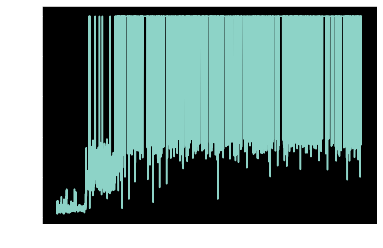

In [10]:
# PLOT REWARDS CURVE
plt.plot(np.arange(NUM_EPISODES), episode_rewards)

In [25]:
# TESTING
observation = env.reset()
state = get_state(observation, bins)
for moves in tqdm(range(MAX_MOVES)):
    env.render()
    action = np.argmax(Q[state])
    # TAKE ACTION
    observation, reward, done, _ = env.step(action)
    state = get_state(observation, bins)
    
    if(done):
        print("MOVES: ",moves)
        break

env.close()

100%|██████████| 200/200 [00:03<00:00, 58.40it/s]
